In [1]:
# Import packages
import numpy as np
import pandas as pd
import math
import datetime
import os
import matplotlib.pyplot as plt
import warnings
import collections
import statsmodels.api as sm
from scipy.stats import t
from sklearn.utils import check_array
from functools import reduce
import seaborn as sns
import warnings
import collections
from matplotlib.pylab import rcParams
warnings.simplefilter(action='ignore', category=Warning)
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None  # default='warn'
sns.set()


## Predictive R200S

Time series averages of predictive 𝑅𝑜𝑜𝑠2 calculated from the test sample at each re-estimation date

In [17]:
# Import dataframes
r2oos_ols = pd.read_csv(r"C:\Users\krist\Documents\Data\r2oos results\r2oos_ols.csv",index_col = "Unnamed: 0")
r2oos_ols_simple = pd.read_csv(r"C:\Users\krist\Documents\Data\r2oos results\r2oos_ols_simple.csv",index_col = "Unnamed: 0")
r2oos_enet = pd.read_csv(r"C:\Users\krist\Documents\Data\r2oos results\r2oos_enet.csv", index_col = "index")
r2oos_pcr = pd.read_csv(r"C:\Users\krist\Documents\Data\r2oos results\r2oos_pcr.csv",index_col = "Unnamed: 0")
r2oos_pls = pd.read_csv(r"C:\Users\krist\Documents\Data\r2oos results\r2oos_pls.csv", index_col = "index")
r2oos_rf = pd.read_csv(r"C:\Users\krist\Documents\Data\r2oos results\r2oos_rf.csv", index_col = "Unnamed: 0")
r2oos_gbrt = pd.read_csv(r"C:\Users\krist\Documents\Data\r2oos results\r2oos_gbrt.csv", index_col = "Unnamed: 0")

In [18]:
#merge on the index column
dfs = [r2oos_ols, r2oos_ols_simple, r2oos_enet, r2oos_pls, r2oos_pcr, r2oos_gbrt, r2oos_rf]
for df in dfs:
    df.reset_index(inplace=True)

df_r2oos  = reduce(lambda left,right: pd.merge(left,right, on = "index"), dfs)
df_r2oos = df_r2oos[["index", "OLS", "OLS-3", "ENet", "PLS", "PCR", "GBRT","RF"]]
df_r2oos

,index,OLS,OLS-3,ENet,PLS,PCR,GBRT,RF
0,Full sample,0.005894,0.004757,0.008252,0.008099,0.008066,0.010896,0.008157
1,Large firms,0.002929,0.004792,0.006368,0.004247,0.006243,0.005249,0.005370
2,Small firms,0.005784,0.003651,0.011201,0.011423,0.010347,0.005550,0.008501


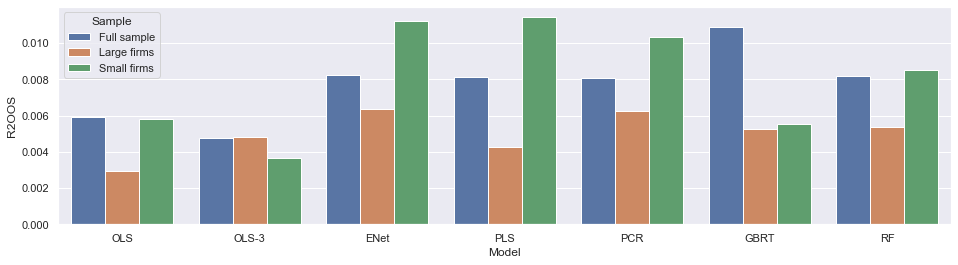

In [19]:
#Plot results
rcParams['figure.figsize'] = 16, 4
df_melted=df_r2oos.melt(id_vars="index",var_name="Model",value_name="R2OOS")
df_melted = df_melted.rename(columns={'index': 'Sample'})
sns.barplot(x=df_melted["Model"], y= df_melted["R2OOS"], hue= df_melted["Sample"]);

In [29]:
df_r2oos.to_excel(r'C:\Users\krist\Documents\Data\r2oos results\r2oos_all.xlsx')

# Diebold-Mariano test


To test the forecast performance of method (1) versus (2), the following test statistic is defined:


### Test Statistic: $D M_{12}=\frac{\bar{d}_{12}}{\widehat{\sigma}_{\bar{d}_{12}}}$



### where $d_{12, t+1}=\frac{1}{n_{3, t+1}} \sum_{i=1}^{n_{3, t+1}}\left(\left(\hat{e}_{i, t+1}^{(1)}\right)^{2}-\left(\hat{e}_{i, t+1}^{(2)}\right)^{2}\right)$


$\hat{e}_{i, t+1}^{(1)}$ and $\hat{e}_{i, t+1}^{(2)}$ denote the prediction error for stock return i at time t from column model 1 and row model $2,  n_{3, t+1}$ accounts for the number of stocks in the testing sample year $\mathrm{t}+1$ and $\bar{d}_{12}$ and $\hat{\sigma}_{\bar{d}_{12}}$ denote mean and Newey-West standard error of $d_{12, t+1}$ over the testing set.

In [2]:
def dm_test(e1, e2, alternative='two_sided', h=1, power=2):
    """
    The Diebold-Mariano test for predictive accuracy.
    The DM test compares the forecast accuracy of different forecasting methods. This implementation is designed
    according to R implementation which could be found here: https://pkg.robjhyndman.com/forecast/reference/dm.test.html
    :param e1: forecast errors from the first method
    :param e2: forecast errors from the second method
    :param alternative: str specifying the alternative hypothesis, 'two_sided' (default one), 'less' or 'greater'
    :param h: forcasting horizon used in calculating errors (e1, e2)
    :param power: power used in the loss function (usually 1 or 2)
    :return: named tuple containing DM statistic and p-value
    Examples
    --------
    >>> e1 = np.random.rand(100)
    >>> e2 = np.random.rand(100)
    >>> dm_test(e1, e2, h=1, power=2, alternative='two_sided')
    dm_test_result(dm_stat=1.023019805162665, p_value=0.30879181140619405)
    """
    alternatives = ['two_sided', 'less', 'greater']
    if alternative not in alternatives:
        raise ValueError(f"alternative must be one of {alternatives}")

    e1 = check_array(e1, ensure_2d=False)
    e2 = check_array(e2, ensure_2d=False)

    d = np.abs(e1) ** power - np.abs(e2) ** power
    n = d.shape[0]
    d_cov = sm.tsa.acovf(d, fft=True, nlag=h - 1)
    d_var = (d_cov[0] + 2 * d_cov[1:].sum()) / n

    if d_var > 0:
        dm_stat = np.mean(d) / np.sqrt(d_var)
    elif h == 1:
        raise ValueError('Variance of DM statistic is zero')
    else:
        warnings.warn('Variance is negative, using horizon h=1', RuntimeWarning)
        return dm_test(e1, e2, alternative=alternative, h=1, power=power)

    # The corrected statistic suggested by HLN
    k = ((n + 1 - 2 * h + h / n * (h - 1)) / n) ** 0.5
    dm_stat *= k

    if alternative == 'two_sided':
        p_value = 2 * t.cdf(-abs(dm_stat), df=n - 1)
    else:
        p_value = t.cdf(dm_stat, df=n - 1)
        if alternative == 'greater':
            p_value = 1 - p_value

    dm_test_result = collections.namedtuple('dm_test_result', ['dm_stat', 'p_value'])
    return dm_test_result(dm_stat=dm_stat, p_value=p_value)

In [22]:
# Import dataframes
OLS = pd.read_csv(r"C:\Users\krist\Documents\Data\Predictions\ols.csv")
OLS_3 = pd.read_csv(r"C:\Users\krist\Documents\Data\Predictions\ols_simple.csv")
ENet = pd.read_csv(r"C:\Users\krist\Documents\Data\Predictions\enet.csv")
PLS = pd.read_csv(r"C:\Users\krist\Documents\Data\Predictions\pls.csv")
PCR = pd.read_csv(r"C:\Users\krist\Documents\Data\Predictions\pcr.csv")
GBRT = pd.read_csv(r"C:\Users\krist\Documents\Data\Predictions\gbrt.csv")
RF = pd.read_csv(r"C:\Users\krist\Documents\Data\Predictions\rf.csv")
df = pd.read_csv(r"C:\Users\krist\Documents\Data\Predictions\enet.csv")

dm_dfs = [OLS, OLS_3, ENet,PLS, PCR, GBRT, RF,df]

for df in dm_dfs:
    df.sort_values(by = ['MonthYear', 'id'], ascending = True)
  

OLS = OLS.set_index(['MonthYear','id'])
OLS_3 = OLS_3.set_index(['MonthYear','id'])
ENet = ENet.set_index(['MonthYear','id'])
PLS = PLS.set_index(['MonthYear','id'])
PCR = PCR.set_index(['MonthYear','id'])
GBRT = GBRT.set_index(['MonthYear','id'])
RF = RF.set_index(['MonthYear','id'])
df = df.set_index(['MonthYear','id'])


# #Save inly columns containing excess returns predictions (yhat) and the true excess returns in t+1 (ytrue)
OLS=OLS[["yhat"]]
OLS_3=OLS_3[["yhat"]]
PLS=PLS[["yhat"]]
ENet=ENet[["yhat"]]
PCR=PCR[["yhat"]]
GBRT=GBRT[["yhat"]]
RF=RF[["yhat"]]
df=df[["y_true"]]

# #rename colums according to the respective model
OLS = OLS.rename(columns={'yhat': 'OLS'})
OLS_3 = OLS_3.rename(columns={'yhat': 'OLS-3'})
PLS = PLS.rename(columns={'yhat': 'PLS'})
ENet = ENet.rename(columns={'yhat': 'ENet'})
PCR = PCR.rename(columns={'yhat': 'PCR'})
GBRT = GBRT.rename(columns={'yhat': 'GBRT'})
RF = RF.rename(columns={'yhat': 'RF'})  


# #prepare for merging
dm_dfs = [OLS, OLS_3, ENet,PLS, PCR, GBRT, RF,df]
for df in dm_dfs:
    df.reset_index(inplace=True)

for df in dm_dfs:
    df["Index"] = df["MonthYear"].astype(str) + df["id"]
    
for df in dm_dfs:    
    df.drop(["MonthYear"], axis = 1, inplace = True)
    df.drop(["id"], axis = 1, inplace = True)

#merge dataframes 
df  = reduce(lambda left,right: pd.merge(left,right, on = "Index"), dm_dfs)  

# #Restore multiindex
df["MonthYear"]=df["Index"].str[:7]
df["id"]=df["Index"].str[7:]
df.drop(["Index"], axis = 1, inplace = True)

df

,OLS,OLS-3,ENet,PLS,PCR,GBRT,RF,y_true,MonthYear,id
0,0.013970,0.011093,0.016103,0.015823,0.015672,0.000585,0.007341,0.035512,2010-01,comp_001166_02W
1,0.011133,0.015908,0.015240,0.013639,0.013568,0.000725,0.007651,-0.041371,2010-01,comp_001661_01W
2,0.019171,0.012309,0.012910,0.011019,0.011608,-0.000684,0.003303,-0.053836,2010-01,comp_002410_04W
3,0.009849,0.010735,0.011465,0.010179,0.010799,-0.001740,0.002349,0.001862,2010-01,comp_002597_02W
4,0.001407,0.003406,0.004352,0.006027,0.004853,-0.005298,-0.007226,0.078967,2010-01,comp_003820_01W
...,...,...,...,...,...,...,...,...,...,...
93412,-0.010683,0.000889,0.002540,-0.003497,-0.000303,0.003477,0.004274,-0.012904,2019-12,comp_330716_01W
93413,-0.005094,0.001201,0.002158,-0.001282,0.001667,0.005012,0.005865,0.005400,2019-12,comp_331115_01W
93414,0.011775,0.006984,0.011536,0.013978,0.004555,-0.001808,0.000225,-0.051340,2019-12,comp_332311_01W
93415,-0.002872,0.005756,0.006443,0.005321,0.011020,0.007719,0.009342,0.003528,2019-12,comp_333885_01W


In [23]:
#################################
# DM test
#################################


models = ["OLS","OLS-3","ENet","PLS","PCR","GBRT","RF"]
column_names = ["OLS","OLS-3","ENet","PLS","PCR","GBRT","RF"]
row_names = ["OLS","OLS-3","ENet","PLS","PCR","GBRT","RF"]



DM_table = pd.DataFrame(columns = column_names, index = row_names)
for i1 in range(len(models)): # OLS,OLS-3, ENet, PLS, PCR, PLS, GBRT, RF
    for i2 in range(len(models)): # OLS,OLS-3, ENet, PLS, PCR, PLS, GBRT, RF
        y_true = df.y_true
        models_method1 = models[i1]
        models_method2 = models[i2]       
        y_hat_1 = df[models_method1]
        y_hat_2 = df[models_method2]
        df['e_hat_1'] = y_true - y_hat_1
        df['e_hat_2'] = y_true - y_hat_2
        if df['e_hat_1'].tolist() == df['e_hat_2'].tolist():
            DM_table.iloc[i1,i2] = 0
        else:
            temp = dm_test(df['e_hat_1'], df['e_hat_2'], alternative='two_sided', h=1, power=2)
            DM_stat = temp[0]
            if temp[1]<=0.01:
                DM_stat = (temp[0].astype(str) + "*")
            if 0.01 < temp[1] <= 0.05:
                DM_stat = (temp[0].astype(str) + "**")
            if  0.05 < temp[1] <= 0.10:
                DM_stat = (temp[0].astype(str) + "***")
            DM_table.iloc[i1,i2] = DM_stat


This table reports pairwise Diebold-Mariano test statistics for the pairwise comparison of the predictive performance of each machine learning models. Positive statistic indicates that the column model outperforms the row model. The test statistic is calculated based on the actual and predicted returns on a 10-year sample (January 2010-December 2019). ,*,*** represent statistical signicance at 1%, 5%, and 10% levels

In [24]:
DM_table

,OLS,OLS-3,ENet,PLS,PCR,GBRT,RF
OLS,0,-1.9016213270534124***,4.786031339316298*,6.069036982733752*,4.075200677343317*,7.080037956156726*,2.4799720501479077**
OLS-3,1.9016213270534124***,0,9.072950807231264*,6.809517109931592*,7.281001627415085*,11.764377720834469*,4.23109016962465*
ENet,-4.786031339316298*,-9.072950807231264*,0,-0.457912,-0.708327,5.203952153673986*,-0.129525
PLS,-6.069036982733752*,-6.809517109931592*,0.457912,0,-0.088577,4.529581852435194*,0.071607
PCR,-4.075200677343317*,-7.281001627415085*,0.708327,0.088577,0,5.183591387074606*,0.116686
GBRT,-7.080037956156726*,-11.764377720834469*,-5.203952153673986*,-4.529581852435194*,-5.183591387074606*,0,-6.221276475124675*
RF,-2.4799720501479077**,-4.23109016962465*,0.129525,-0.071607,-0.116686,6.221276475124675*,0


In [25]:
DM_table.to_excel(r'C:\Users\krist\Documents\Data\Predictions\DM_table.xlsx')

## Model comparison of relative variable importance

This figure shows the ordering of all stock-level characteristics ranked by their overall importance. The overall variable ranks derived by ranking the relative contribution of each variable within a given model, and summing the ranks across all models, with the most influential variables on the top and the least influential on the bottom. The color gradients within each column indicate the most important (darker cells) to the least important (white) characteristics


In [5]:
var_imp_ols = pd.read_csv(r"C:\Users\krist\Documents\Data\variable importance\var_imp_ols.csv")
var_imp_enet = pd.read_csv(r"C:\Users\krist\Documents\Data\variable importance\var_imp_enet.csv")
var_imp_pls = pd.read_csv(r"C:\Users\krist\Documents\Data\variable importance\var_imp_pls.csv")
var_imp_pcr = pd.read_csv(r"C:\Users\krist\Documents\Data\variable importance\var_imp_pcr.csv")
var_imp_gbrt = pd.read_csv(r"C:\Users\krist\Documents\Data\variable importance\var_imp_gbrt.csv")
var_imp_rf = pd.read_csv(r"C:\Users\krist\Documents\Data\variable importance\var_imp_rf.csv")



In [4]:
var_imp_ols.rename(columns={'var_imp': 'OLS'}, inplace=True)
var_imp_enet.rename(columns={'var_imp': 'ENet'}, inplace=True)
var_imp_pls.rename(columns={'var_imp': 'PLS'}, inplace=True)
var_imp_pcr.rename(columns={'var_imp': 'PCR'}, inplace=True)
var_imp_gbrt.rename(columns={'var_imp': 'GBRT'}, inplace=True)
var_imp_rf.rename(columns={'var_imp': 'RF'}, inplace=True)

imp_dfs = [var_imp_ols, var_imp_enet, var_imp_pls,var_imp_pcr,var_imp_gbrt, var_imp_rf]
var_imp_all = reduce(lambda left,right: pd.merge(left,right, on = "Feature"), imp_dfs)
var_imp_all=var_imp_all.set_index("Feature")
var_imp_all.to_excel(r'C:\Users\krist\Documents\Data\variable importance\all models.xlsx')
var_imp_all.head()

,OLS,ENet,PLS,PCR,GBRT,RF
Feature,,,,,,
ret_12_7,0.126870,0.057536,-0.202527,0.107479,0.036959,-0.001478
ret_9_1,0.120514,0.060424,-0.108250,0.043955,0.027567,0.080141
ret_1_0,0.091626,0.023529,-0.105784,0.004993,0.044284,0.002098
inv_gr1a,0.065099,0.249373,-0.079480,-0.019425,0.032799,-0.006072
noa_at,0.064506,0.029844,-0.079178,-0.007157,0.000069,0.006466


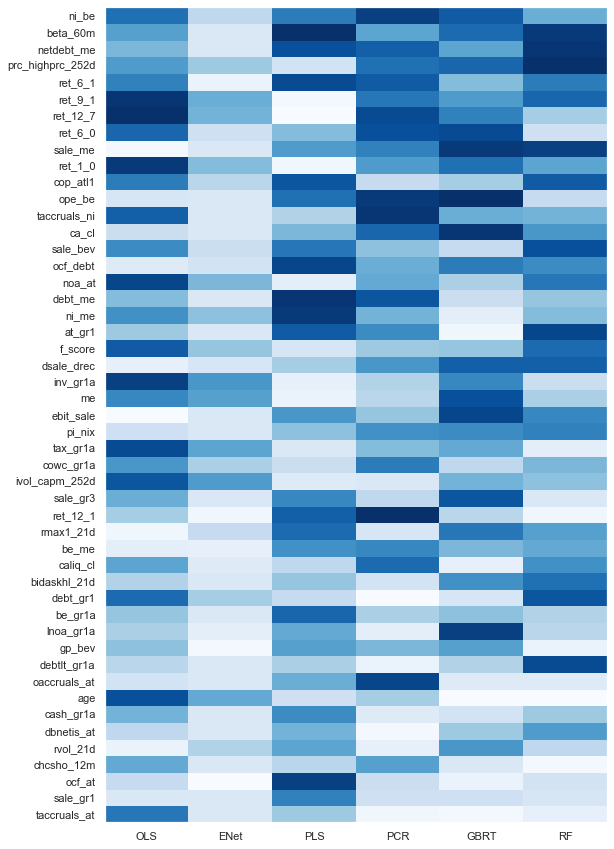

In [8]:
#create new columns containing the asigned rank per variable per model
var_imp_all['rank_OLS'] = pd.factorize(var_imp_all['OLS'], sort=True)[0] +1
var_imp_all['rank_ENet'] = pd.factorize(var_imp_all['ENet'], sort=True)[0] + 1
var_imp_all['rank_PLS'] = pd.factorize(var_imp_all['PLS'], sort=True)[0] + 1
var_imp_all['rank_PCR'] = pd.factorize(var_imp_all['PCR'], sort=True)[0] + 1
var_imp_all['rank_GBRT'] = pd.factorize(var_imp_all['GBRT'], sort=True)[0] + 1
var_imp_all['rank_RF'] = pd.factorize(var_imp_all['RF'], sort=True)[0] + 1

#retain only the ranks (without actual values)
var_imp_all=var_imp_all.iloc[:, 6:]
#rename colums
var_imp_all.rename(columns=lambda x: x.replace('rank_', ''), inplace=True)

#calculate the overall rank per variable and sort them accordingly
var_imp_all["sum"] = var_imp_all.sum(axis=1)
var_imp_all = var_imp_all.sort_values(by = ['sum'], ascending = True)
var_imp_all=var_imp_all.iloc[:, :-1]

#plot
plt.rcParams["figure.figsize"] = (9,15)
plt.pcolor(var_imp_all,cmap= "Blues")
plt.yticks(np.arange(0.5, len(var_imp_all.index), 1), var_imp_all.index)
plt.xticks(np.arange(0.5, len(var_imp_all.columns), 1), var_imp_all.columns)
plt.plot( figsize=(30, 10))
plt.savefig('Characteristic importance.png')
plt.show()

In [10]:
var_imp_all.to_excel(r'C:\Users\krist\Documents\Data\variable importance\all models ranks.xlsx')

# Cumulative performance of expected return-sorted portfolios with monthly restructuring

In [6]:
#import dataframe for both equal and value weighting scheme
ret_OLS_ew = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\ols_ew.csv", index_col = "MonthYear1")
ret_OLS_vw = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\ols_vw.csv", index_col = "MonthYear1")
ret_OLS_3_ew = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\ols_ew_simple.csv", index_col = "MonthYear1")
ret_OLS_3_vw = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\ols_vw_simple.csv", index_col = "MonthYear1")
ret_PLS_ew = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\pls_ew.csv", index_col = "MonthYear1")
ret_PLS_vw = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\pls_vw.csv", index_col = "MonthYear1")
ret_PCR_ew = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\pcr_ew.csv", index_col = "MonthYear1")
ret_PCR_vw = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\pcr_vw.csv", index_col = "MonthYear1")
ret_ENet_ew = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\enet_ew.csv", index_col = "MonthYear1")
ret_ENet_vw = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\enet_vw.csv", index_col = "MonthYear1")
ret_GBRT_ew = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\gbrt_ew.csv", index_col = "MonthYear1")
ret_GBRT_vw = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\gbrt_vw.csv", index_col = "MonthYear1")
ret_RF_ew = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\rf_ew.csv", index_col = "MonthYear1")
ret_RF_vw = pd.read_csv(r"C:\Users\krist\Documents\Data\cumulative_log_returns\rf_vw.csv", index_col = "MonthYear1")


#Rename columns to differentiate between models
ret_OLS_ew.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_ew": "ols_long"
                           ,"cumulative_log_return_short_ew": "ols_short"}, inplace=True)


ret_OLS_vw.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_vw": "ols_long"
                           ,"cumulative_log_return_short_vw": "ols_short"}, inplace=True)

ret_OLS_3_ew.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_ew": "ols_3_long"
                           ,"cumulative_log_return_short_ew": "ols_3_short"}, inplace=True)


ret_OLS_3_vw.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_vw": "ols_3_long"
                           ,"cumulative_log_return_short_vw": "ols_3_short"}, inplace=True)


ret_PLS_ew.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_ew": "pls_long"
                           ,"cumulative_log_return_short_ew": "pls_short"}, inplace=True)


ret_PLS_vw.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_vw": "pls_long"
                           ,"cumulative_log_return_short_vw": "pls_short"}, inplace=True)

ret_ENet_ew.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_ew": "enet_long"
                           ,"cumulative_log_return_short_ew": "enet_short"}, inplace=True)


ret_ENet_vw.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_vw": "enet_long"
                           ,"cumulative_log_return_short_vw": "enet_short"}, inplace=True)

ret_PCR_ew.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_ew": "pcr_long"
                           ,"cumulative_log_return_short_ew": "pcr_short"}, inplace=True)


ret_PCR_vw.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_vw": "pcr_long"
                           ,"cumulative_log_return_short_vw": "pcr_short"}, inplace=True)



ret_GBRT_ew.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_ew": "gbrt_long"
                           ,"cumulative_log_return_short_ew": "gbrt_short"}, inplace=True)


ret_GBRT_vw.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_vw": "gbrt_long"
                           ,"cumulative_log_return_short_vw": "gbrt_short"}, inplace=True)

ret_RF_ew.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_ew": "rf_long"
                           ,"cumulative_log_return_short_ew": "rf_short"}, inplace=True)


ret_RF_vw.rename(columns={'cumulative_log_return_dax': 'DAX'
                           ,"cumulative_log_return_long_vw": "rf_long"
                           ,"cumulative_log_return_short_vw": "rf_short"}, inplace=True)

In [7]:
#Merge dataframes to compare results for the equall erighting schme 
ret_ENet_ew=ret_ENet_ew.reset_index()
ret_dfs = [ret_OLS_ew, ret_OLS_3_ew,ret_ENet_ew,ret_PLS_ew, ret_PCR_ew, ret_GBRT_ew, ret_RF_ew]
cum_ret_ew  = reduce(lambda left,right: pd.merge(left,right, on = "DAX"), ret_dfs)
cum_ret_ew=cum_ret_ew.set_index("MonthYear1")
cum_ret_ew

,ols_long,ols_short,DAX,ols_3_long,ols_3_short,enet_long,enet_short,pls_long,pls_short,pcr_long,pcr_short,gbrt_long,gbrt_short,rf_long,rf_short
MonthYear1,,,,,,,,,,,,,,,
2010-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02,-0.000476,-0.024065,0.093190,-0.024944,-0.005501,0.018354,-0.021750,0.011413,-0.022711,0.007774,-0.017382,-0.003378,-0.025320,0.009659,-0.037021
2010-03,0.087135,-0.005883,0.089288,0.078679,0.000371,0.108302,0.005927,0.093981,-0.004004,0.096055,-0.000145,0.056334,0.008695,0.074180,0.002081
2010-04,0.087318,-0.011415,0.060048,0.058147,-0.016187,0.117289,-0.007104,0.103229,-0.019442,0.111164,-0.010512,0.075431,0.008340,0.089287,0.003006
2010-05,-0.030772,-0.134052,0.059586,-0.099259,-0.111307,-0.005091,-0.127646,-0.016815,-0.135346,-0.015016,-0.129178,-0.051998,-0.121405,-0.033825,-0.124231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,2.449056,-0.678096,0.818398,0.945170,-0.538746,2.819823,-0.602629,3.297749,-0.671084,3.028899,-0.634433,1.825179,-0.473674,1.622543,-0.520081
2019-09,2.532306,-0.677265,0.878597,0.978785,-0.532607,2.853409,-0.593936,3.346299,-0.663637,3.108199,-0.626362,1.881940,-0.466596,1.658180,-0.505968
2019-10,2.717509,-0.666554,0.927967,1.048735,-0.521242,3.046793,-0.580125,3.572023,-0.650313,3.315793,-0.617938,2.013096,-0.450214,1.788752,-0.499278


In [16]:
#Save to excel
cum_ret_ew.to_excel(r'C:\Users\krist\Documents\Data\cumulative_log_returns\ew_all.xlsx')

In [8]:
#Merge dataframes to compare results for the value erighting schme 
ret_ENet_vw=ret_ENet_vw.reset_index()
ret_dfs = [ret_OLS_vw, ret_OLS_3_vw,ret_ENet_vw,ret_PLS_vw, ret_PCR_vw, ret_GBRT_vw, ret_RF_vw]
cum_ret_vw  = reduce(lambda left,right: pd.merge(left,right, on = "DAX"), ret_dfs)
cum_ret_vw=cum_ret_vw.set_index("MonthYear1")
cum_ret_vw

,ols_long,ols_short,DAX,ols_3_long,ols_3_short,enet_long,enet_short,pls_long,pls_short,pcr_long,pcr_short,gbrt_long,gbrt_short,rf_long,rf_short
MonthYear1,,,,,,,,,,,,,,,
2010-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02,-0.025828,-0.052683,0.093190,-0.043287,0.018621,-0.035368,-0.075494,-0.039422,-0.067176,-0.043254,-0.057730,-0.011614,-0.018697,-0.026969,-0.042781
2010-03,0.042862,-0.039031,0.089288,0.053298,0.027602,0.038465,0.013005,0.024906,0.018797,0.028851,0.020826,0.028336,0.034133,0.037901,0.014601
2010-04,0.012930,-0.042395,0.060048,0.031414,0.006774,0.024976,-0.006453,0.004084,-0.005423,0.016754,0.007604,0.008644,0.029848,0.019385,0.012898
2010-05,-0.110873,-0.208973,0.059586,-0.109827,-0.095690,-0.074244,-0.155043,-0.097248,-0.160447,-0.074444,-0.171594,-0.132765,-0.113572,-0.104439,-0.134648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,0.761035,-0.681864,0.818398,0.467450,-0.476520,0.451223,-0.409595,0.876641,-0.660259,0.674816,-0.628909,0.461159,0.122918,0.550718,0.108186
2019-09,0.832082,-0.684876,0.878597,0.484258,-0.455614,0.482670,-0.396465,0.912878,-0.665705,0.731636,-0.614973,0.507485,0.154926,0.582766,0.136225
2019-10,0.897156,-0.678427,0.927967,0.535406,-0.422482,0.544556,-0.355339,1.004228,-0.638050,0.803690,-0.592094,0.540099,0.169623,0.645153,0.156682


In [18]:
#Save to excel
cum_ret_vw.to_excel(r'C:\Users\krist\Documents\Data\cumulative_log_returns\vw_all.xlsx')

<AxesSubplot:xlabel='MonthYear1'>

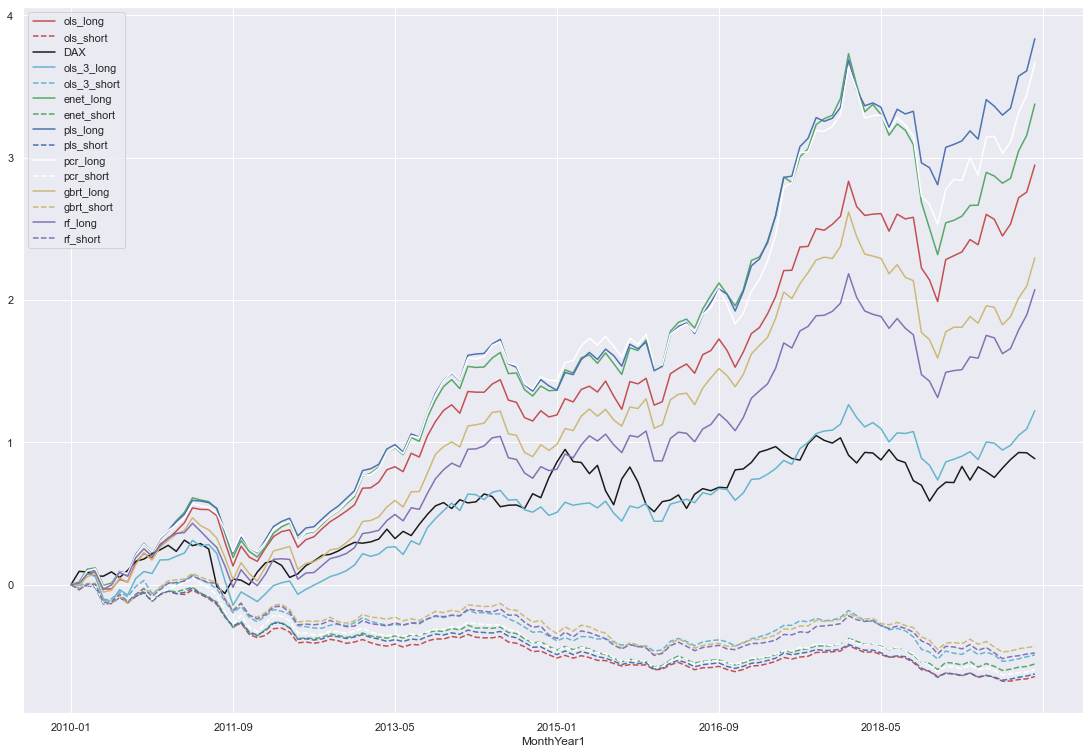

In [9]:
#Plot cumulative log returns for the equal weighting scheme
cum_ret_ew.plot(grid=True,figsize=(19, 13),style={'ols_long': 'r', 'ols_short': '--r',
                                                 'enet_long': 'g', 'enet_short': '--g',
                                                 'pls_long': 'b', 'pls_short': '--b',
                                                  'pcr_long': 'w', 'pcr_short': '--w',
                                                  'ols_3_long': 'c', 'ols_3_short': '--c',
                                                  'gbrt_long': 'y', 'gbrt_short': '--y',
                                                  'rf_long': 'm', 'rf_short': '--m',
                                                  "DAX": "k"})

<AxesSubplot:xlabel='MonthYear1'>

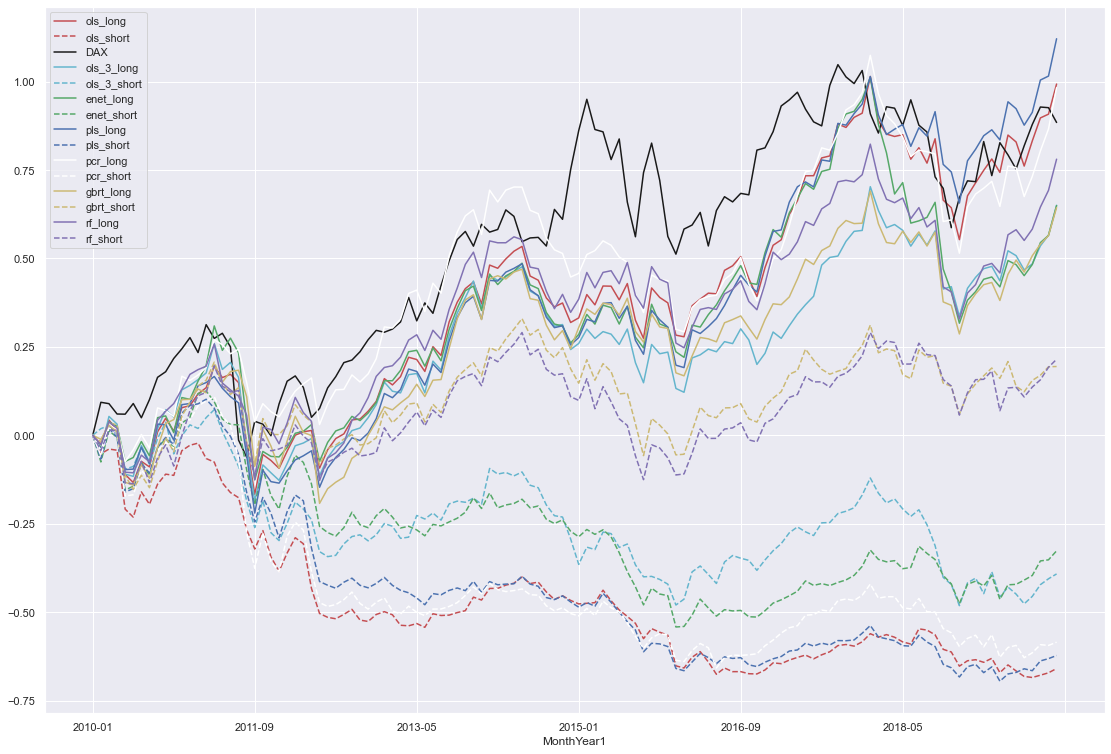

In [10]:
#Plot cumulative log returns for the value weighting scheme
cum_ret_vw.plot(grid=True,figsize=(19, 13),style={'ols_long': 'r', 'ols_short': '--r',
                                                 'enet_long': 'g', 'enet_short': '--g',
                                                 'pls_long': 'b', 'pls_short': '--b',
                                                  'pcr_long': 'w', 'pcr_short': '--w',
                                                  'ols_3_long': 'c', 'ols_3_short': '--c',
                                                  'gbrt_long': 'y', 'gbrt_short': '--y',
                                                  'rf_long': 'm', 'rf_short': '--m',
                                                  "DAX": "k"})